# Analysis 3 (Adaptive): Drift Detection Methodology

Dataset loaded with shape: (100000, 4)
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
Training set shape: (80000, 4)
Testing set shape: (20000, 4)
RMSE: 0.9364
Evaluating segment 1
RMSE: 0.9385
KS Test: Drift detected in segment 1, retraining triggered.
Evaluating segment 2
RMSE: 0.9380
KS Test: Drift detected in segment 2, retraining triggered.
Introducing drift in segment 3...
Evaluating segment 3
RMSE: 0.9345
Introducing drift in segment 4...
Evaluating segment 4
RMSE: 0.9329
Retraining events (KS Test): 2
Retraining events (Threshold): 0


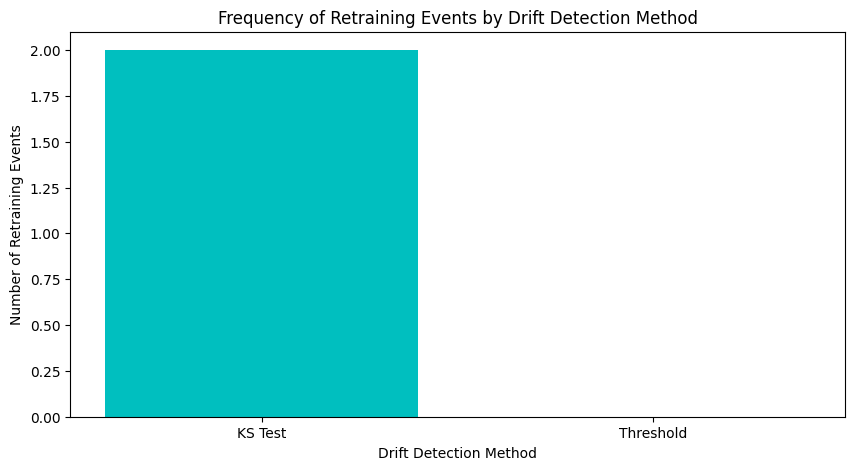

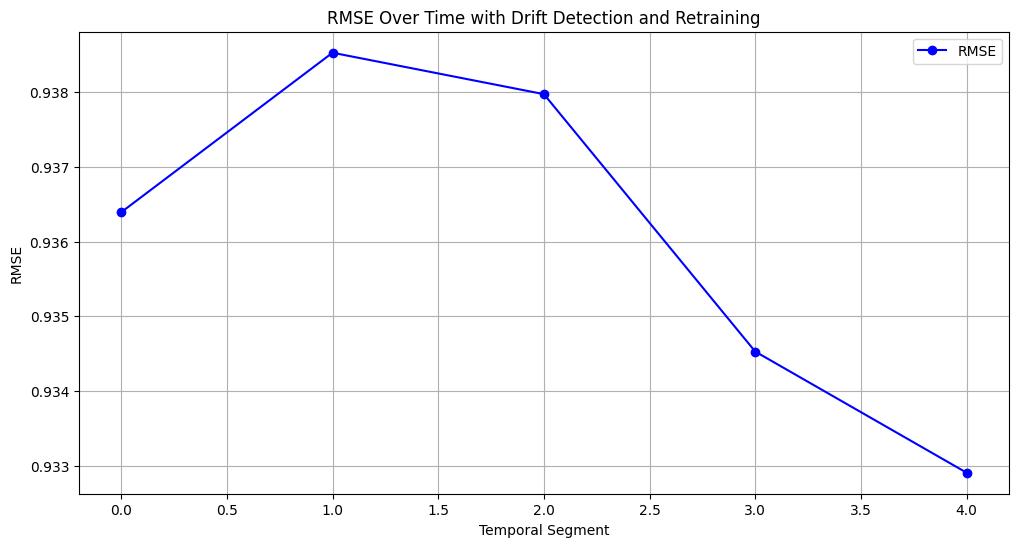

In [10]:
import numpy as np
import pandas as pd
from pipeline import Pipeline
from continuous_learning import ContinuousLearner
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load dataset and partition it temporally
pipeline = Pipeline()
ratings_file = "/teamspace/studios/this_studio/u.data"
metadata_file = "/teamspace/studios/this_studio/u.item"
pipeline.load_dataset(ratings_file)

# Perform temporal partitioning to simulate evolution of user preferences
temporal_segments = []
n_splits = 5  # Number of temporal segments
current_train_df, temp_df = pipeline.partition_data(partition_type='temporal', test_size=1/n_splits)
temporal_segments.append(current_train_df)

# Further partition temp_df into remaining temporal segments
for _ in range(n_splits - 1):
    current_train_df, temp_df = train_test_split(temp_df, test_size=1/(n_splits - 1))
    temporal_segments.append(current_train_df)

# Initialize models and fit them on the first segment
pipeline.initialize_models(ratings_file=ratings_file, metadata_file=metadata_file)
pipeline.fit_models()

# Calculate baseline RMSE using the initial segment
train_df, test_df = train_test_split(temporal_segments[0], test_size=0.2, random_state=42)
rmse_collaborative = pipeline.collaborative_model.evaluate()
baseline_rmse = [rmse_collaborative] * 50  # Replicate the initial RMSE to create a baseline distribution

# Set up ContinuousLearner with the initial baseline RMSE values
learner = ContinuousLearner(baseline_rmse=baseline_rmse)

# Loop over remaining segments, calculate RMSE, and detect drift
retraining_events = {'KS Test': 0, 'Threshold': 0}
rmse_values = [rmse_collaborative]  # Store RMSE values for subsequent segments

THRESHOLD_RATIO = 1.02  # RMSE must increase by 2% or more to trigger retraining

for i, segment in enumerate(temporal_segments[1:], 1):
    # Introduce artificial drift by adding noise to user ratings in the current segment
    if i >= 3:  # Introducing drift in later segments to observe drift detection behavior
        print(f"Introducing drift in segment {i}...")
        segment["rating"] = segment["rating"] + np.random.normal(1.0, 0.5, len(segment))
        segment["rating"] = segment["rating"].clip(1, 5)  # Ensure ratings stay within bounds (1, 5)

    print(f"Evaluating segment {i}")

    # Train and evaluate the model on this segment
    pipeline.fit_models()
    train_df, test_df = train_test_split(segment, test_size=0.2, random_state=42)
    rmse = pipeline.collaborative_model.evaluate()

    # Append to RMSE values
    rmse_values.append(rmse)

    # Apply KS Test for drift detection
    drift_detected_ks, p_value = learner.detect_drift([rmse], return_pvalue=True)
    if drift_detected_ks:
        retraining_events['KS Test'] += 1
        print(f"KS Test: Drift detected in segment {i}, retraining triggered.")

    # Apply RMSE threshold for drift detection
    if rmse > np.mean(baseline_rmse) * THRESHOLD_RATIO:
        retraining_events['Threshold'] += 1
        print(f"Threshold: Drift detected in segment {i}, retraining triggered.")

print(f"Retraining events (KS Test): {retraining_events['KS Test']}")
print(f"Retraining events (Threshold): {retraining_events['Threshold']}")

# Plot retraining events
plt.figure(figsize=(10, 5))
plt.bar(retraining_events.keys(), retraining_events.values(), color='c')
plt.xlabel("Drift Detection Method")
plt.ylabel("Number of Retraining Events")
plt.title("Frequency of Retraining Events by Drift Detection Method")
plt.show()

# Plot RMSE over temporal segments to observe how retraining affects performance
plt.figure(figsize=(12, 6))
plt.plot(range(len(rmse_values)), rmse_values, marker='o', color='b', label='RMSE')
plt.xlabel("Temporal Segment")
plt.ylabel("RMSE")
plt.title("RMSE Over Time with Drift Detection and Retraining")
plt.legend()
plt.grid(True)
plt.show()

# Analysis 4 (Personalization): Diversity Measures


Analyzing Intra-List Diversity...
   item  relevance_score  diversity_score  total_score
0  1536              5.0         5.000000     5.000000
1  1500              5.0         5.000000     5.000000
2  1653              5.0         5.000000     5.000000
3  1122              5.0         3.750000     4.375000
4  1467              5.0         3.634941     4.317470
5  1599              5.0         3.500000     4.250000
6  1189              5.0         3.333333     4.166667
7  1293              5.0         3.333333     4.166667
8   814              5.0         3.000000     4.000000
9  1201              5.0         2.500000     3.750000

Analyzing Shannon Entropy...
   item  relevance_score  diversity_score  total_score
0  1467              5.0         9.196484     7.098242
1  1122              5.0         8.838807     6.919404
2  1293              5.0         4.778499     4.889250
3  1599              5.0         4.751353     4.875676
4   814              5.0         4.337816     4.668908


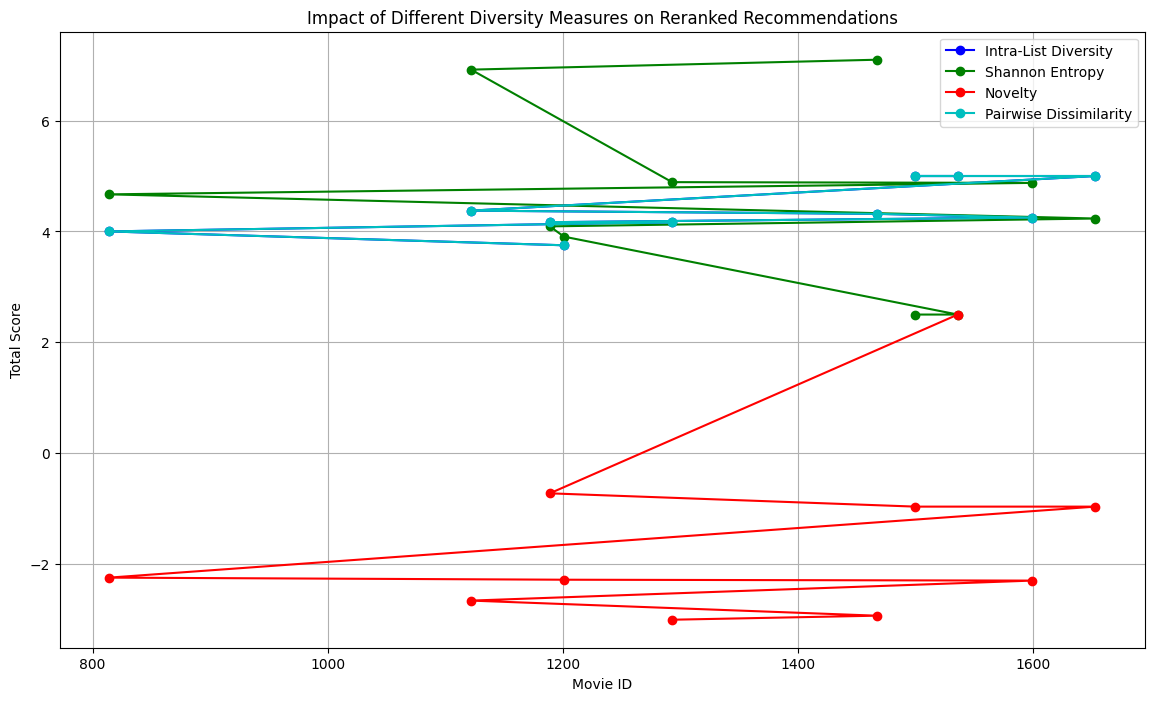

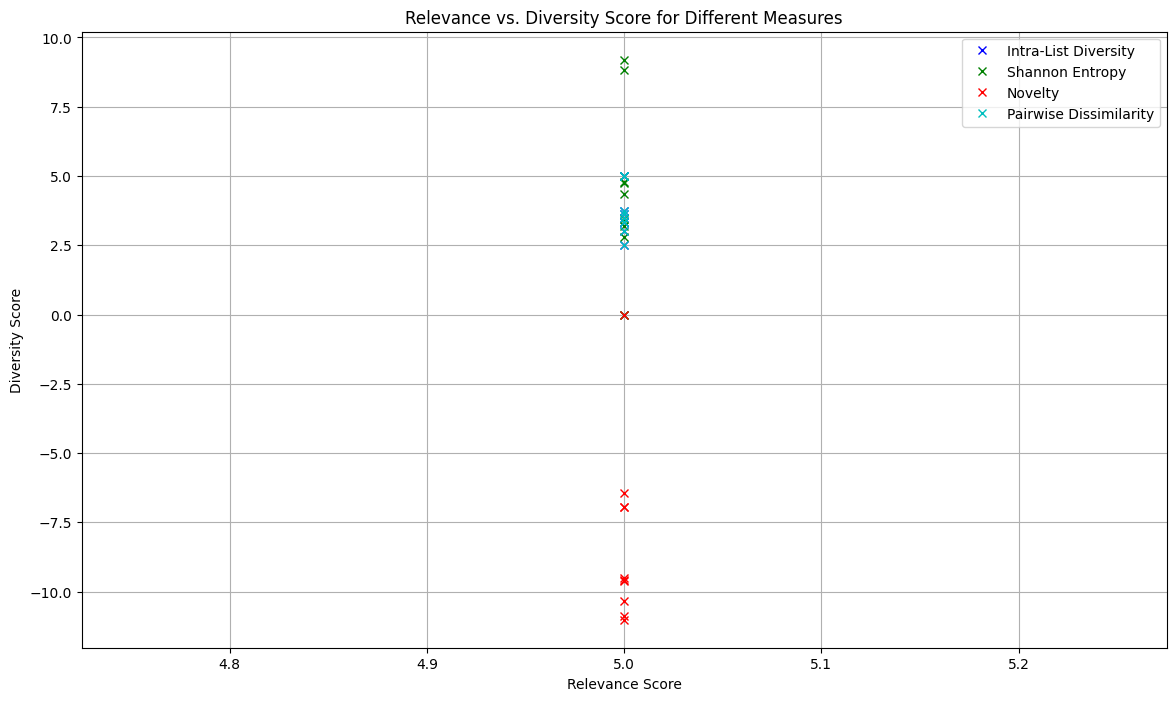

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from diversifier import Diversifier, calculate_intra_list_diversity, calculate_shannon_entropy, calculate_novelty, calculate_pairwise_dissimilarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
ratings_file = 'u.data'
metadata_file = 'u.item'

# Load initial ratings data
ratings_data = pd.read_csv(
    ratings_file,
    sep='\t',
    names=['user_id', 'item_id', 'rating', 'timestamp']
)

# Load item metadata
metadata = pd.read_csv(
    metadata_file,
    sep='|',
    encoding='latin-1',
    names=[
        'movieId', 'title', 'release_date', 'video_release_date',
        'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
        'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
        'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
        'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
    ]
)

# Prepare initial recommendations by taking top rated items
initial_recommendations = ratings_data.groupby('item_id')['rating'].mean().reset_index()
initial_recommendations.columns = ['item', 'score']
initial_recommendations = initial_recommendations.sort_values(by='score', ascending=False).head(10)

# Define the different diversity measures for analysis
diversity_measures = [
    ('Intra-List Diversity', calculate_intra_list_diversity),
    ('Shannon Entropy', calculate_shannon_entropy),
    ('Novelty', lambda selected_indices, _: calculate_novelty(selected_indices, ratings_data['item_id'].value_counts().to_dict())),
    ('Pairwise Dissimilarity', calculate_pairwise_dissimilarity)
]

# Prepare results dictionary to store analysis data
analysis_results = {}

# Perform analysis for each diversity measure
for measure_name, measure_function in diversity_measures:
    print(f"\nAnalyzing {measure_name}...")
    diversifier = Diversifier(diversity_measures=[measure_function], top_n=10, metadata_file=metadata_file)
    
    # Rerank the recommendations using the current diversity measure
    reranked = diversifier.rerank(initial_recommendations, alpha=0.5)
    analysis_results[measure_name] = reranked

    # Display the reranked recommendations for the current diversity measure
    print(reranked)

# Plot the effect of different diversity measures on recommendation reranking
plt.figure(figsize=(14, 8))
colors = ['b', 'g', 'r', 'c', 'm']

for idx, (measure_name, reranked_df) in enumerate(analysis_results.items()):
    plt.plot(
        reranked_df['item'],
        reranked_df['total_score'],
        marker='o',
        linestyle='-',
        color=colors[idx % len(colors)],
        label=f'{measure_name}'
    )

plt.xlabel('Movie ID')
plt.ylabel('Total Score')
plt.title('Impact of Different Diversity Measures on Reranked Recommendations')
plt.legend()
plt.grid(True)
plt.show()

# Visualize Diversity and Relevance Trade-Offs for Each Measure
plt.figure(figsize=(14, 8))

for idx, (measure_name, reranked_df) in enumerate(analysis_results.items()):
    plt.plot(
        reranked_df['relevance_score'],
        reranked_df['diversity_score'],
        marker='x',
        linestyle='',
        color=colors[idx % len(colors)],
        label=f'{measure_name}'
    )

plt.xlabel('Relevance Score')
plt.ylabel('Diversity Score')
plt.title('Relevance vs. Diversity Score for Different Measures')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_1328/3456391176.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='Measure', y='diversity_score', palette='viridis')


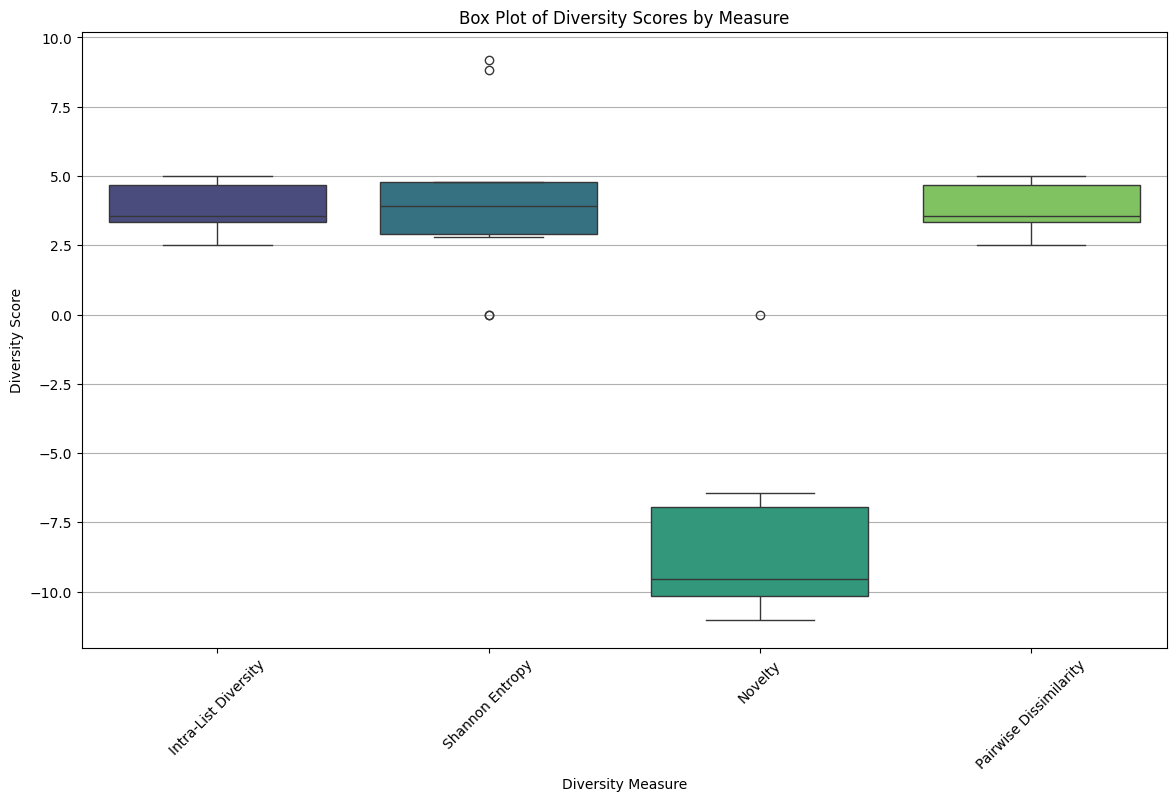

In [5]:
plt.figure(figsize=(14, 8))

sns.boxplot(data=combined_df, x='Measure', y='diversity_score', palette='viridis')

plt.xlabel('Diversity Measure')
plt.ylabel('Diversity Score')
plt.title('Box Plot of Diversity Scores by Measure')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

/tmp/ipykernel_1328/2991871236.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=combined_df, x='Measure', y='diversity_score', inner='quartile', palette='Set2')


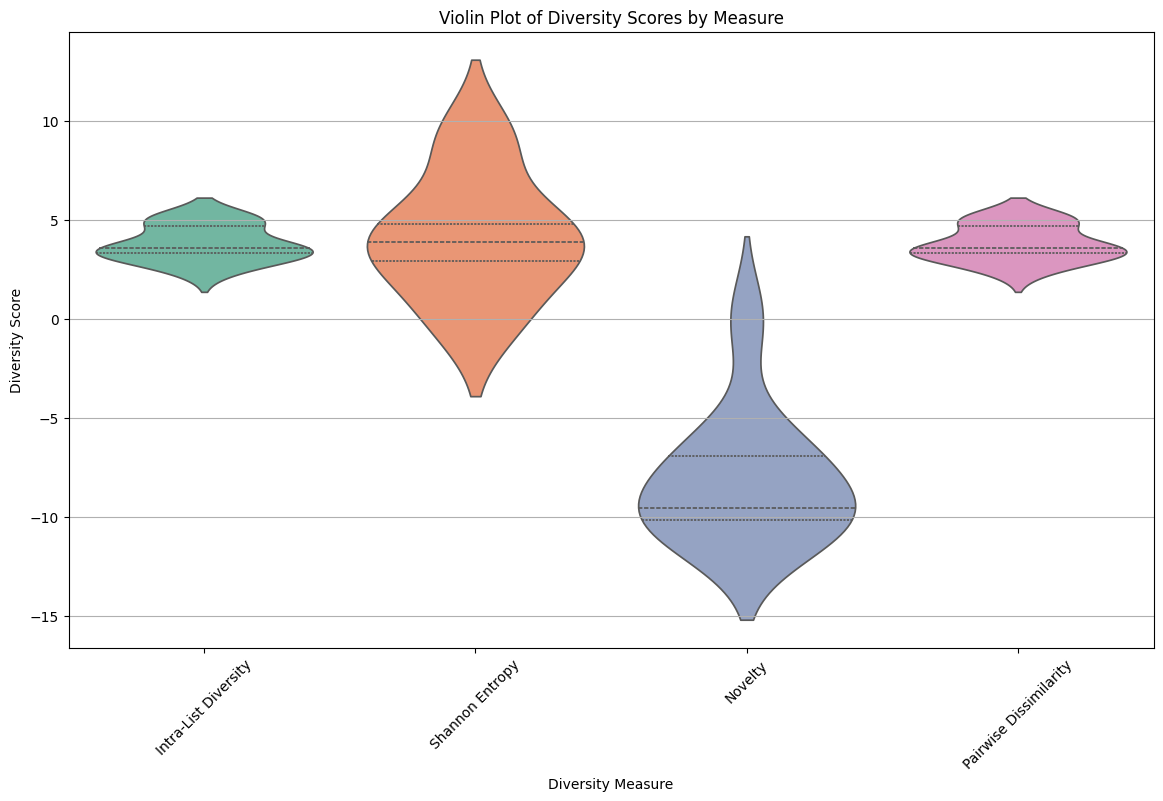

In [6]:
plt.figure(figsize=(14, 8))

sns.violinplot(data=combined_df, x='Measure', y='diversity_score', inner='quartile', palette='Set2')

plt.xlabel('Diversity Measure')
plt.ylabel('Diversity Score')
plt.title('Violin Plot of Diversity Scores by Measure')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

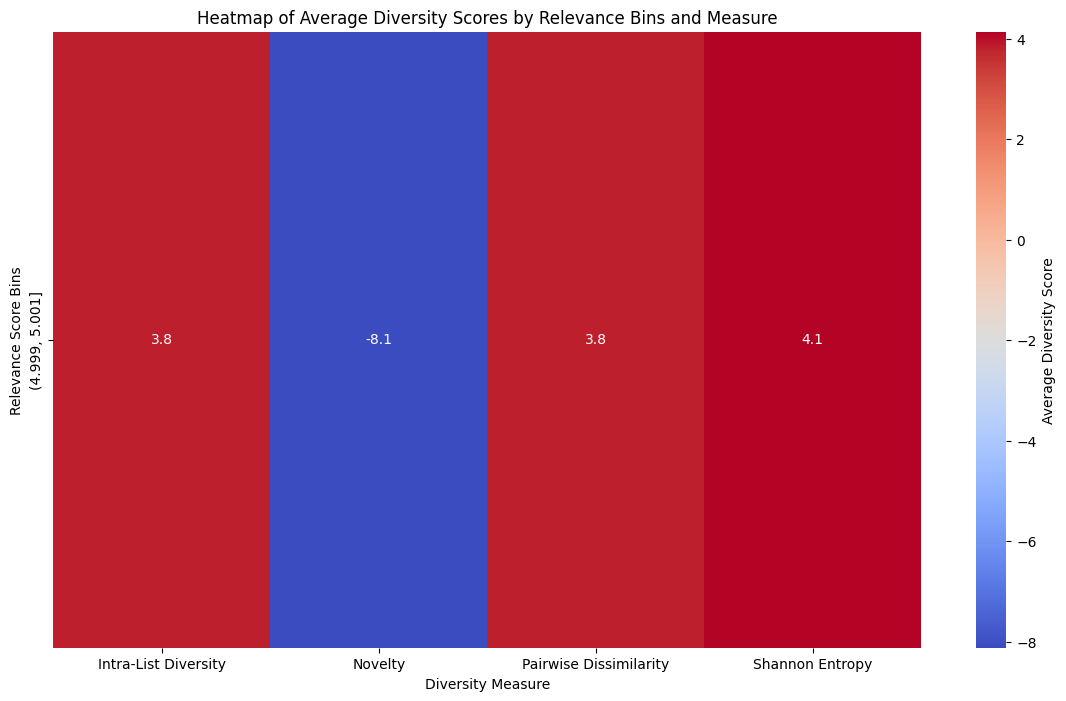

In [7]:
# Create bins for relevance scores and aggregate data
combined_df['relevance_bin'] = pd.cut(combined_df['relevance_score'], bins=5)

# Create a pivot table with diversity scores averaged per measure and relevance bin
heatmap_data = combined_df.pivot_table(values='diversity_score', index='relevance_bin', columns='Measure', aggfunc='mean')

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Average Diversity Score'})

plt.title('Heatmap of Average Diversity Scores by Relevance Bins and Measure')
plt.xlabel('Diversity Measure')
plt.ylabel('Relevance Score Bins')
plt.show()

# Analysis 5 (Personalization): Optimal Number of Reranked Recommendations

Dataset loaded with shape: (100000, 4)
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
Training set shape: (80000, 4)
Testing set shape: (20000, 4)


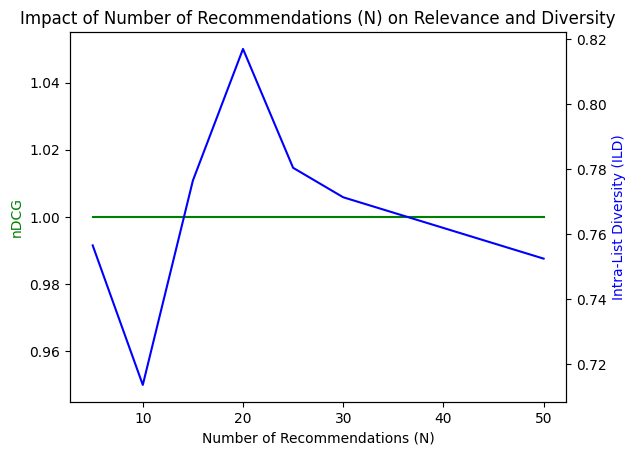

,N,nDCG,ILD
0,5,1.0,0.756571
1,10,1.0,0.713710
2,15,1.0,0.776506
3,20,1.0,0.816936
4,25,1.0,0.780412
5,30,1.0,0.771360
6,50,1.0,0.752512


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pipeline import Pipeline
from diversifier import calculate_intra_list_diversity
from sklearn.metrics import ndcg_score

def evaluate_optimal_n(pipeline, user_id, n_values, genre_vectors):
    # Store results in a dictionary
    results = {
        "N": [],
        "nDCG": [],
        "ILD": []
    }

    # Iterate over the list of top-N values
    for n in n_values:
        # Get the recommendations
        rankings = pipeline.recommender.rank_items(user_id=user_id, top_n=n)

        # Calculate relevance (nDCG)
        true_relevance = np.ones(len(rankings))
        predicted_scores = rankings['score'].values
        ndcg = ndcg_score([true_relevance], [predicted_scores])

        # Calculate diversity (ILD)
        selected_indices = rankings['item'].values
        ild = calculate_intra_list_diversity(selected_indices, genre_vectors)

        # Store the results
        results["N"].append(n)
        results["nDCG"].append(ndcg)
        results["ILD"].append(ild)

    # Convert results to a DataFrame for analysis
    results_df = pd.DataFrame(results)
    return results_df

def plot_results(results_df):
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(results_df['N'], results_df['nDCG'], 'g-')
    ax2.plot(results_df['N'], results_df['ILD'], 'b-')

    ax1.set_xlabel('Number of Recommendations (N)')
    ax1.set_ylabel('nDCG', color='g')
    ax2.set_ylabel('Intra-List Diversity (ILD)', color='b')

    plt.title('Impact of Number of Recommendations (N) on Relevance and Diversity')
    plt.show()

# Initialize the Pipeline and Load Dataset
pipeline = Pipeline()
pipeline.load_dataset('u.data')
train_df, test_df = pipeline.partition_data()
pipeline.initialize_models(ratings_file='u.data', metadata_file='u.item')
pipeline.fit_models()

# Specific user_id to generate recommendations for
user_id = 196

# Define different values of N to evaluate
n_values = [5, 10, 15, 20, 25, 30, 50]

# Load genre vectors for ILD calculation from the metadata
genre_vectors = pipeline.diversifier.movies.iloc[:, 5:].values

# Evaluate the optimal number of N
results_df = evaluate_optimal_n(pipeline, user_id, n_values, genre_vectors)

# Plot the results to visualize the trade-off between relevance and diversity
plot_results(results_df)

# Display the results in DataFrame format
results_df

# Bonus Analysis: Bias Analysis in Recommendations

In [7]:
import pandas as pd

# Load the datasets
u_data = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
u_item = pd.read_csv('u.item', sep='|', encoding='latin-1', 
                     names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                            'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                            'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                            'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
u_user = pd.read_csv('u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# Merge user data with the interactions
data_with_users = pd.merge(u_data, u_user, on='user_id')

# Merge item data with the interactions
full_data = pd.merge(data_with_users, u_item, left_on='item_id', right_on='movie_id')

print(full_data.head())

   user_id  item_id  rating  timestamp  age gender  occupation zip_code  \
0      196      242       3  881250949   49      M      writer    55105   
1      305      242       5  886307828   23      M  programmer    94086   
2        6      242       4  883268170   42      M   executive    98101   
3      234      242       4  891033261   60      M     retired    94702   
4       63      242       3  875747190   31      M   marketing    75240   

   movie_id         title  ... Fantasy  Film-Noir Horror  Musical  Mystery  \
0       242  Kolya (1996)  ...       0          0      0        0        0   
1       242  Kolya (1996)  ...       0          0      0        0        0   
2       242  Kolya (1996)  ...       0          0      0        0        0   
3       242  Kolya (1996)  ...       0          0      0        0        0   
4       242  Kolya (1996)  ...       0          0      0        0        0   

   Romance  Sci-Fi  Thriller  War  Western  
0        0       0         0    0  

In [8]:
# Group by gender and calculate average rating
avg_rating_by_gender = full_data.groupby('gender')['rating'].mean()
print(avg_rating_by_gender)

# Group by gender and calculate average ratings for specific genres
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 
          'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

avg_genre_rating_by_gender = full_data.groupby('gender')[genres].mean()
print(avg_genre_rating_by_gender)

gender
F    3.531507
M    3.529289
Name: rating, dtype: float64
          Action  Adventure  Animation  Children    Comedy     Crime  \
gender                                                                 
F       0.211422   0.122028   0.038656  0.086713  0.313442  0.069697   
M       0.271304   0.142903   0.035147  0.066658  0.293078  0.084312   

        Documentary     Drama   Fantasy  Film-Noir    Horror   Musical  \
gender                                                                   
F          0.007265  0.427661  0.014103   0.014957  0.046503  0.056022   
M          0.007689  0.388998  0.013318   0.018152  0.055481  0.047293   

         Mystery   Romance    Sci-Fi  Thriller       War   Western  
gender                                                              
F       0.051049  0.227584  0.102137  0.197591  0.085043  0.014413  
M       0.052936  0.183181  0.136022  0.226044  0.097078  0.019970  


Dataset loaded with shape: (100000, 4)
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
Training set shape: (80000, 4)
Testing set shape: (20000, 4)
RMSE: 0.9338
Collaborative Filtering Model RMSE: 0.9338100338313141
Content-Based Filtering Model RMSE: 1.770201401084926
Average popularity of all items: 59.45303210463734
Average popularity of initial recommended items: 185.09606986899564
Average popularity of reranked items: 185.09606986899564


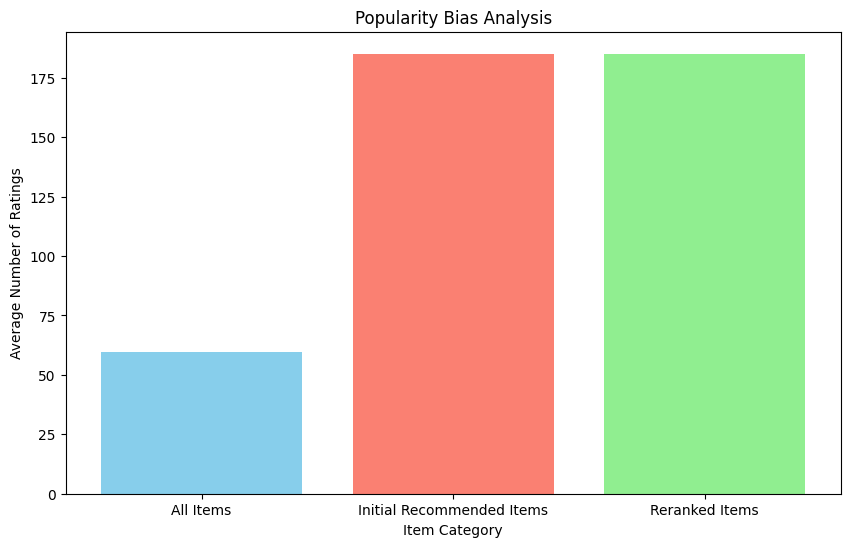

In [13]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from pipeline import Pipeline

# Initialize the Pipeline
pipeline = Pipeline()

# Load dataset
pipeline.load_dataset('u.data')

# Partition dataset
train_df, test_df = pipeline.partition_data()

# Initialize models with the appropriate files
pipeline.initialize_models(ratings_file='u.data', metadata_file='u.item')

# Fit the models
pipeline.fit_models()

# Evaluate models
pipeline.evaluate_models()

# Get Recommendations for All Users
# Generate recommendations for all users in the dataset
all_users = pipeline.ratings_df['user_id'].unique()
all_initial_recommended_items = []
all_reranked_items = []

for user_id in all_users:
    # Get initial rankings
    rankings = pipeline.recommender.rank_items(user_id=user_id, top_n=10)
    
    # Collect initial recommended items
    all_initial_recommended_items.extend(rankings['item'].tolist())
    
    # Rerank if diversifier exists
    if pipeline.diversifier:
        reranked = pipeline.diversifier.rerank(rankings, alpha=0.7)
        reranked_items = reranked['item'].tolist()
    else:
        reranked_items = rankings['item'].tolist()
    
    # Collect reranked items
    all_reranked_items.extend(reranked_items)

# Convert to DataFrame
initial_recommended_items_df = pd.DataFrame(all_initial_recommended_items, columns=['item_id'])
reranked_items_df = pd.DataFrame(all_reranked_items, columns=['item_id'])

# Calculate Popularity Metrics
# Calculate item popularity for each item (number of ratings per item)
item_popularity = pipeline.ratings_df['item_id'].value_counts().reset_index()
item_popularity.columns = ['item_id', 'num_ratings']

# Calculate the average popularity for all items
avg_popularity_all = item_popularity['num_ratings'].mean()

# Calculate average popularity for initial recommended items
initial_popularity = item_popularity[item_popularity['item_id'].isin(initial_recommended_items_df['item_id'])]
avg_popularity_initial = initial_popularity['num_ratings'].mean()

# Calculate average popularity for reranked items
reranked_popularity = item_popularity[item_popularity['item_id'].isin(reranked_items_df['item_id'])]
avg_popularity_reranked = reranked_popularity['num_ratings'].mean()

# Display Results
print(f'Average popularity of all items: {avg_popularity_all}')
print(f'Average popularity of initial recommended items: {avg_popularity_initial}')
print(f'Average popularity of reranked items: {avg_popularity_reranked}')

# Plot the Popularity Bias
plt.figure(figsize=(10, 6))
plt.bar(['All Items', 'Initial Recommended Items', 'Reranked Items'], 
        [avg_popularity_all, avg_popularity_initial, avg_popularity_reranked], 
        color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Popularity Bias Analysis')
plt.xlabel('Item Category')
plt.ylabel('Average Number of Ratings')
plt.show()